# Anomaly Detection With Autoencoders

Autoencoders are neural networks trained to reconstruct their input data. When trained on **normal (non-anomalous)** data only, they learn to compress and reconstruct the patterns of that distribution.

During inference, if the autoencoder is presented with **anomalous data** — data it has never seen and cannot reconstruct well — the **reconstruction error** becomes large. This error can be used as an **anomaly score**.

In this notebook, we will:

- Build and train a simple autoencoder on synthetic **2D Gaussian data** representing normal events.
- Inject **outlier anomalies** (uniformly distributed points outside the normal data range).
- Use **reconstruction loss** to detect and score anomalies.
- Visualize and evaluate the performance of our anomaly detection approach.

This provides a minimal, interpretable example of unsupervised anomaly detection using autoencoders.

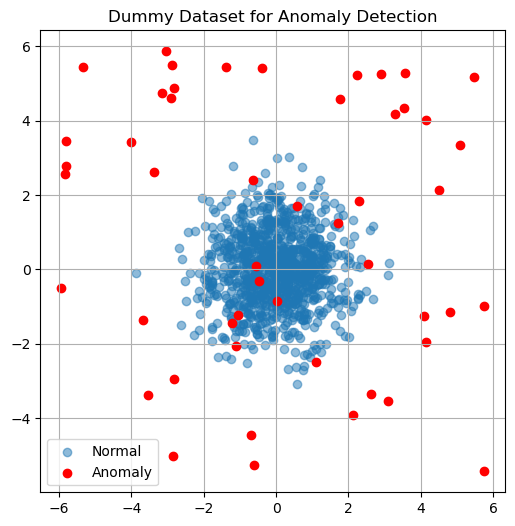

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Normal data: 2D Gaussian
n_normal = 1000
normal_data = np.random.normal(loc=0, scale=1, size=(n_normal, 2))

# Anomalies: Uniform in a wider range
n_anomalies = 50
anomalies = np.random.uniform(low=-6, high=6, size=(n_anomalies, 2))

# Combine
X = np.vstack([normal_data, anomalies])
y = np.hstack([np.zeros(n_normal), np.ones(n_anomalies)])  # 0=normal, 1=anomaly

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Normal', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Anomaly', color='red')
plt.legend()
plt.title("Dummy Dataset for Anomaly Detection")
plt.grid(True)

## Step 1: Generate the Data

We simulate a simple 2D anomaly detection task:

- **Normal data**: Sampled from a standard 2D Gaussian distribution (`N(0,1)`).
- These will be used to train the autoencoder.

In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# Generate normal data: 2D Gaussian
n_normal = 10000
normal_data = np.random.normal(loc=0.0, scale=1.0, size=(n_normal, 2)).astype(np.float32)

# Convert to PyTorch tensors
tensor_data = torch.from_numpy(normal_data)
dataset = TensorDataset(tensor_data)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
## Step 2: Build the Model

In [4]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, latent_dim=2):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=32, output_dim=2):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.decoder(x)

class Autoencoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)


## Step 3: Training

In [5]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        x_batch = batch[0].to(device)
        outputs = model(x_batch)
        loss = criterion(outputs, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.6f}")


Epoch 01 | Loss: 0.463084
Epoch 02 | Loss: 0.005815
Epoch 03 | Loss: 0.001212
Epoch 04 | Loss: 0.000651
Epoch 05 | Loss: 0.000423
Epoch 06 | Loss: 0.000313
Epoch 07 | Loss: 0.000256
Epoch 08 | Loss: 0.000220
Epoch 09 | Loss: 0.000196
Epoch 10 | Loss: 0.000173
Epoch 11 | Loss: 0.000165
Epoch 12 | Loss: 0.000146
Epoch 13 | Loss: 0.000128
Epoch 14 | Loss: 0.000114
Epoch 15 | Loss: 0.000113
Epoch 16 | Loss: 0.000099
Epoch 17 | Loss: 0.000091
Epoch 18 | Loss: 0.000092
Epoch 19 | Loss: 0.000098
Epoch 20 | Loss: 0.000078


## Visualize Reconstruction

After training the autoencoder, we can evaluate how well it reconstructs the normal inputs:
- Blue points are the original normal data.
- Orange points are the reconstructions from the autoencoder.

Good reconstruction means the autoencoder has learned the normal data manifold.

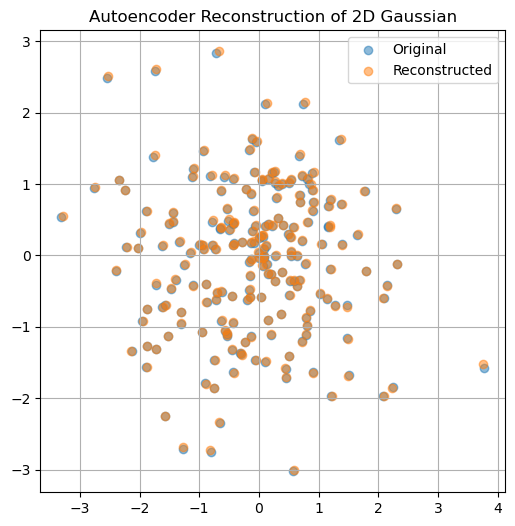

In [6]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    test_samples = tensor_data[:200]
    recon = model(test_samples.to(device)).cpu()

plt.figure(figsize=(6, 6))
plt.scatter(test_samples[:, 0], test_samples[:, 1], alpha=0.5, label="Original")
plt.scatter(recon[:, 0], recon[:, 1], alpha=0.5, label="Reconstructed")
plt.legend()
plt.title("Autoencoder Reconstruction of 2D Gaussian")
plt.grid(True)
plt.show()


## Step 4: Create Anomalies and Combine with Normal Data

We now simulate anomalies and combine them with normal data for testing:
- Anomalies: Random points uniformly spread in a wider range (e.g., [-6, 6]), outside the training distribution.

In [7]:
# Generate anomalies: uniform distribution in a wider range
n_anomaly = 100
anomalies = np.random.uniform(low=-6, high=6, size=(n_anomaly, 2)).astype(np.float32)

# Combine normal and anomaly data
X_all = np.vstack([normal_data, anomalies])
y_all = np.hstack([np.zeros(len(normal_data)), np.ones(len(anomalies))])  # 0 = normal, 1 = anomaly

# Convert to tensor
X_all_tensor = torch.from_numpy(X_all)

## Step 5: Compute Reconstruction Loss as **Anomaly Score**

We use the reconstruction loss from the autoencoder as an unsupervised anomaly score.
- Normal points (seen during training) should have low reconstruction loss.
- Anomalies (unseen structure) typically have high reconstruction loss.

In [8]:
model.eval()
with torch.no_grad():
    X_all_tensor = X_all_tensor.to(device)
    recon = model(X_all_tensor)
    loss_per_sample = ((X_all_tensor - recon) ** 2).sum(dim=1)  # MSE per sample
    anomaly_scores = loss_per_sample.cpu().numpy()

## Step 6: Visualize Scores and ROC Curve

We evaluate how well reconstruction loss separates normal from anomalous points using the ROC curve.
- **ROC**: plots True Positive Rate vs False Positive Rate at various thresholds.
- **AUC**: Area under the ROC curve — higher is better (1.0 = perfect, 0.5 = random).

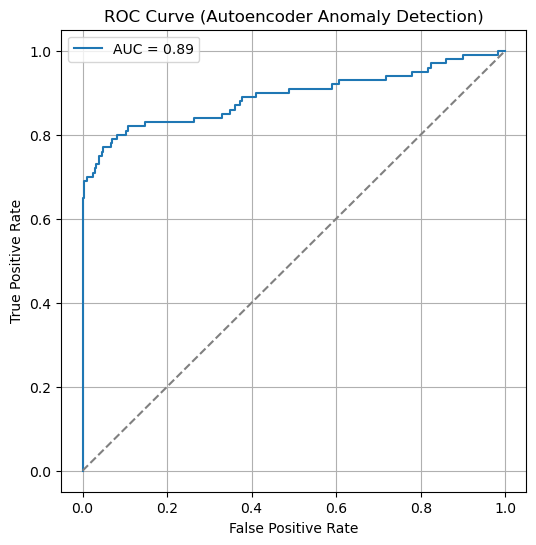

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_all, anomaly_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Autoencoder Anomaly Detection)")
plt.grid(True)
plt.legend()
plt.show()


## Step 7: Visualize Data by Score

We now visualize the anomaly scores on the original 2D plane:
- Color represents reconstruction loss.
- Normal points are plotted in blue, anomalies in red.
- Darker red = more anomalous (higher reconstruction error).

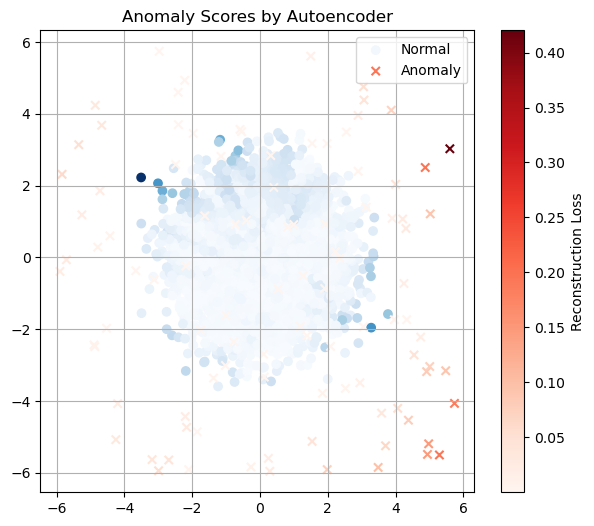

In [10]:
plt.figure(figsize=(7, 6))
plt.scatter(X_all[y_all == 0, 0], X_all[y_all == 0, 1],
            c=anomaly_scores[y_all == 0], cmap='Blues', label='Normal')
plt.scatter(X_all[y_all == 1, 0], X_all[y_all == 1, 1],
            c=anomaly_scores[y_all == 1], cmap='Reds', label='Anomaly', marker='x')
plt.colorbar(label="Reconstruction Loss")
plt.title("Anomaly Scores by Autoencoder")
plt.legend()
plt.grid(True)
plt.show()

To calculate the **accuracy** (how correct is the model in classifying anomalies), you need to binarize the anomaly scores using a threshold and compare to the true labels (`y_all`):
### 1. Choose a threshold:

In [11]:
threshold = np.percentile(anomaly_scores, 95)  # Top 5% most "anomalous"
y_pred = (anomaly_scores > threshold).astype(int)

### 2. Compute accuracy / precision / recall:

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_all, y_pred)
prec = precision_score(y_all, y_pred)
rec = recall_score(y_all, y_pred)
f1 = f1_score(y_all, y_pred)

print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}")

Accuracy: 0.95, Precision: 0.15, Recall: 0.75, F1: 0.25


### 3. Visualize correct/incorrect predictions

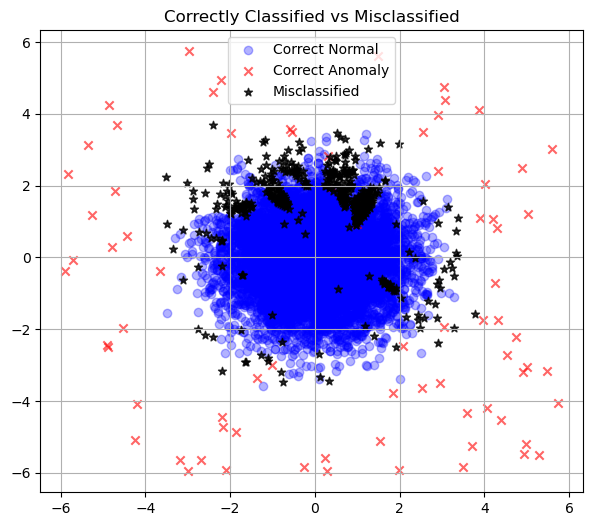

In [13]:
correct = y_pred == y_all
incorrect = ~correct

plt.figure(figsize=(7, 6))
plt.scatter(X_all[correct & (y_all == 0), 0], X_all[correct & (y_all == 0), 1],
            c='blue', label='Correct Normal', alpha=0.3)
plt.scatter(X_all[correct & (y_all == 1), 0], X_all[correct & (y_all == 1), 1],
            c='red', label='Correct Anomaly', alpha=0.6, marker='x')
plt.scatter(X_all[incorrect, 0], X_all[incorrect, 1],
            c='black', label='Misclassified', alpha=0.8, marker='*')
plt.legend()
plt.title("Correctly Classified vs Misclassified")
plt.grid(True)
plt.show()


In [14]:
import copy
# Save the autoencoder for later comparison with VAE
autoencoder = copy.deepcopy(model)  # `model` is the trained AE

## Now, Let's Create a Simple Variational Autoencoder (VAE) for 2D input

In [15]:
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return self.fc5(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## VAE Training

In [16]:
# VAE Loss functions as explained in Lecture 9
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    vae.train()
    total_loss = 0

    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1:02d} | VAE Loss: {avg_loss:.4f}")


Epoch 01 | VAE Loss: 1.9594
Epoch 02 | VAE Loss: 1.8486
Epoch 03 | VAE Loss: 1.8267
Epoch 04 | VAE Loss: 1.7952
Epoch 05 | VAE Loss: 1.7165
Epoch 06 | VAE Loss: 1.7097
Epoch 07 | VAE Loss: 1.6922
Epoch 08 | VAE Loss: 1.6863
Epoch 09 | VAE Loss: 1.6854
Epoch 10 | VAE Loss: 1.7036
Epoch 11 | VAE Loss: 1.6827
Epoch 12 | VAE Loss: 1.7114
Epoch 13 | VAE Loss: 1.7004
Epoch 14 | VAE Loss: 1.6953
Epoch 15 | VAE Loss: 1.7043
Epoch 16 | VAE Loss: 1.6885
Epoch 17 | VAE Loss: 1.6963
Epoch 18 | VAE Loss: 1.6845
Epoch 19 | VAE Loss: 1.6918
Epoch 20 | VAE Loss: 1.7034


## Now You Can Compare AE and VAE

In [17]:
# Use the same anomaly dataset and compute anomaly scores:
# For Autoencoder:
with torch.no_grad():
    recon_ae = autoencoder(X_all_tensor)
    ae_scores = ((X_all_tensor - recon_ae) ** 2).sum(dim=1).cpu().numpy()

# For VAE
with torch.no_grad():
    recon_vae, _, _ = vae(X_all_tensor)
    vae_scores = ((X_all_tensor - recon_vae) ** 2).sum(dim=1).cpu().numpy()

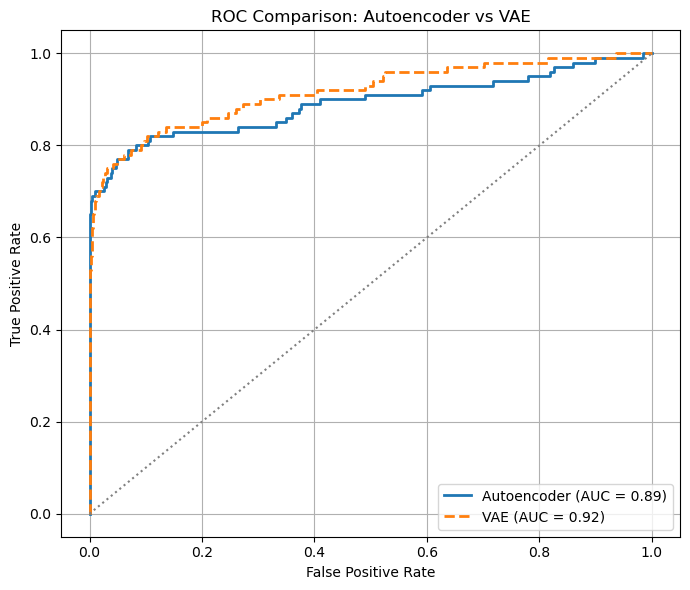

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_ae, tpr_ae, _ = roc_curve(y_all, ae_scores)
auc_ae = auc(fpr_ae, tpr_ae)

fpr_vae, tpr_vae, _ = roc_curve(y_all, vae_scores)
auc_vae = auc(fpr_vae, tpr_vae)

# Plot both curves
plt.figure(figsize=(7, 6))
plt.plot(fpr_ae, tpr_ae, label=f"Autoencoder (AUC = {auc_ae:.2f})", linewidth=2)
plt.plot(fpr_vae, tpr_vae, label=f"VAE (AUC = {auc_vae:.2f})", linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], linestyle=':', color='gray')  # diagonal line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison: Autoencoder vs VAE")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


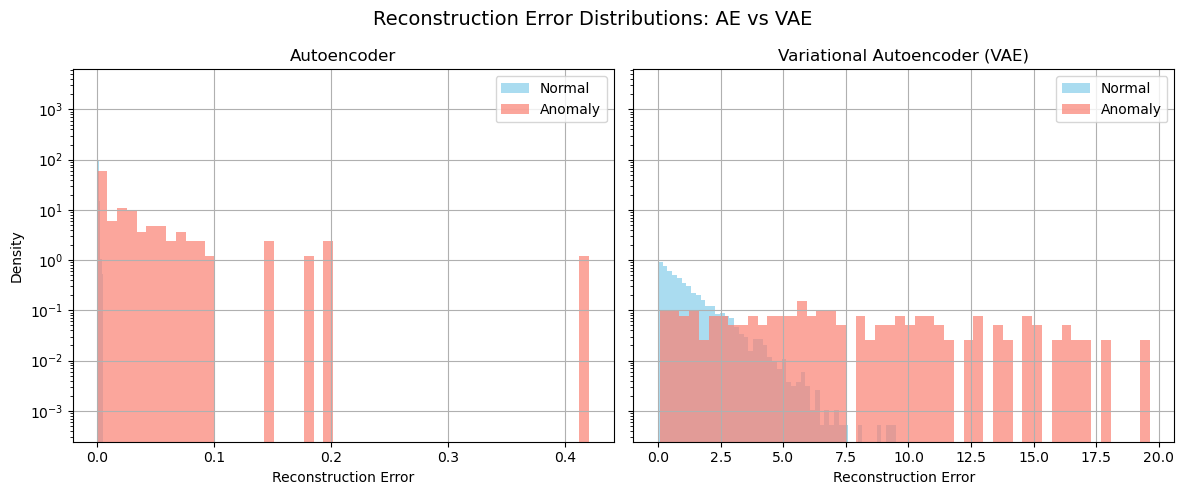

In [19]:
import matplotlib.pyplot as plt

# Split AE scores
ae_normal = ae_scores[y_all == 0]
ae_anomaly = ae_scores[y_all == 1]

# Split VAE scores
vae_normal = vae_scores[y_all == 0]
vae_anomaly = vae_scores[y_all == 1]

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Autoencoder plot
axs[0].hist(ae_normal, bins=50, alpha=0.7, label='Normal', color='skyblue', density=True)
axs[0].hist(ae_anomaly, bins=50, alpha=0.7, label='Anomaly', color='salmon', density=True)
axs[0].set_title("Autoencoder")
axs[0].set_xlabel("Reconstruction Error")
axs[0].set_ylabel("Density")
axs[0].grid(True)
axs[0].legend()

# VAE plot
axs[1].hist(vae_normal, bins=50, alpha=0.7, label='Normal', color='skyblue', density=True)
axs[1].hist(vae_anomaly, bins=50, alpha=0.7, label='Anomaly', color='salmon', density=True)
axs[1].set_title("Variational Autoencoder (VAE)")
axs[1].set_xlabel("Reconstruction Error")
axs[1].grid(True)
axs[1].legend()

plt.suptitle("Reconstruction Error Distributions: AE vs VAE", fontsize=14)
plt.tight_layout()
plt.semilogy()
plt.show()


## Unsupervised Anomaly Detection on Realistic Collider Data

In this section, we apply an **unsupervised autoencoder** to a realistic dataset from **high-energy physics**, using data provided by the **LHC Olympics 2020** anomaly detection challenge.

### LHC Olympics

The [LHC Olympics 2020](https://lhco2020.github.io/homepage/) is a community challenge focused on identifying **model-independent anomalies** in collider data using machine learning techniques. Participants are encouraged to detect unusual physics signals (e.g., new particles or exotic decays) without assuming a specific signal model. The challenge reflects real-world difficulties in physics searches: we don't always know what we're looking for.

### The Dataset

The LHC Olympics dataset consists of simulated **particle-level events**, where each event contains a fixed number of **reconstructed particles** with the following kinematic features:

- $p_T$: Transverse momentum  
- $\eta$: Pseudorapidity  
- $\phi$: Azimuthal angle (circular variable)

The dataset is stored in **HDF5 format** as a matrix with shape:
`(N_events, 700 × 3)` = `(N_events, 2100)`  


Where:
- Each row corresponds to a single event
- Each event contains up to **700 particles**, each with 3 features
- The data is **padded with zeros** if an event contains fewer than 700 particles

We reshape each event into shape `(700, 3)` and **truncate to 200 particles** per event for efficiency. A **padding mask** is constructed based on zero $p_T$ values, so that our model can ignore padded inputs during training and attention computations.

### Goal

Our goal is to train an autoencoder **only on background (normal) events**, and then evaluate its ability to identify anomalous events (e.g., signal) based on **reconstruction error**.

In [20]:
import pandas as pd
import torch
import numpy as np

# Load first 10k events 
# TODO: Please make sure you downloaded the data first!
df = pd.read_hdf("LHCOlympics/events_LHCO2020_backgroundMC_Pythia.h5", key="df", start=0, stop=10000)

# Convert to numpy and reshape to (N_events, 700, 3)
X = df.values.astype(np.float32).reshape(-1, 700, 3)  # [10000, 700, 3]

# Truncate to 200 particles
X_trunc = X[:, :200, :]  # [10000, 200, 3]

# Create padding mask: True where pT == 0 (means this is a padded particle)
# pT is the first feature: [:, :, 0]
padding_mask = X_trunc[:, :, 0] == 0  # [10000, 200], dtype: bool

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_trunc, dtype=torch.float32)         # [B, 200, 3]
padding_mask_tensor = torch.tensor(padding_mask, dtype=torch.bool)  # [B, 200]

### Define an AutoEncoder model

In [21]:
import torch
import torch.nn as nn

class MLPMHABlock(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.activation = nn.GELU()
        self.mha = nn.MultiheadAttention(
            embed_dim=out_dim, num_heads=num_heads, batch_first=True
        )
        self.norm = nn.LayerNorm(out_dim)

    def forward(self, x, padding_mask=None):
        # x: [B, T, D]
        x = self.linear(x)
        x = self.activation(x)
        residual = x
        # key_padding_mask: shape [B, T], True = ignore
        attn_out, _ = self.mha(x, x, x, key_padding_mask=padding_mask)
        x = self.norm(residual + attn_out)
        return x

class MLPMHAAutoEncoder(nn.Module):
    def __init__(self, in_dim=3, proj_dim=256, num_heads=4, latent_dim=16):
        super().__init__()
        assert proj_dim % num_heads == 0
        assert latent_dim % num_heads == 0

        self.input_proj = nn.Linear(in_dim, proj_dim)
        self.output_proj = nn.Linear(proj_dim, in_dim)

        self.encoder = nn.ModuleList([
            MLPMHABlock(proj_dim, 256, num_heads),
            MLPMHABlock(256, 128, num_heads),
            MLPMHABlock(128, latent_dim, num_heads),
        ])

        self.decoder = nn.ModuleList([
            MLPMHABlock(latent_dim, 128, num_heads),
            MLPMHABlock(128, 256, num_heads),
            MLPMHABlock(256, proj_dim, num_heads),
        ])

    def forward(self, x, padding_mask=None):
        # x: [B, T, 3], padding_mask: [B, T] (True = ignore)
        x = self.input_proj(x)  # → [B, T, 256]
        for layer in self.encoder:
            x = layer(x, padding_mask=padding_mask)
        for layer in self.decoder:
            x = layer(x, padding_mask=padding_mask)
        x = self.output_proj(x)  # → [B, T, 3]
        return x

### Training Loop

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Assuming you already have:
# - X_tensor: shape [N, 200, 3]
# - padding_mask_tensor: shape [N, 200], dtype=torch.bool

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, padding_mask_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPMHAAutoEncoder(in_dim=3, proj_dim=256, num_heads=8, latent_dim=16).to(device)

# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Loss function: masked MSE
def masked_mse_loss(x, x_recon, mask):
    # x, x_recon: [B, T, 3], mask: [B, T]
    loss = ((x - x_recon) ** 2).sum(dim=-1)  # [B, T]
    return loss[~mask].mean()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_x, batch_mask in dataloader:
        batch_x = batch_x.to(device)           # [B, T, 3]
        batch_mask = batch_mask.to(device)     # [B, T]

        optimizer.zero_grad()
        x_recon = model(batch_x, padding_mask=batch_mask)  # pass mask
        loss = masked_mse_loss(batch_x, x_recon, batch_mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.6f}")

Epoch 01 | Loss: 2732.234878
Epoch 02 | Loss: 2262.536494
Epoch 03 | Loss: 1828.654352
Epoch 04 | Loss: 1470.505106
Epoch 05 | Loss: 1182.458395
Epoch 06 | Loss: 951.315879
Epoch 07 | Loss: 768.396551
Epoch 08 | Loss: 621.110806
Epoch 09 | Loss: 505.732479
Epoch 10 | Loss: 413.474070
Epoch 11 | Loss: 355.733490
Epoch 12 | Loss: 320.072233
Epoch 13 | Loss: 287.304861
Epoch 14 | Loss: 259.734757
Epoch 15 | Loss: 232.483713
Epoch 16 | Loss: 209.072036
Epoch 17 | Loss: 188.484864
Epoch 18 | Loss: 169.398529
Epoch 19 | Loss: 152.369882
Epoch 20 | Loss: 136.244573


## Let's test on Blackbox Data

### Step 1: Load the BlackBox Data and Ground Truth Labels

In [23]:
# Load only the first 5,000 BlackBox events
df_bb1 = pd.read_hdf("LHCOlympics/events_LHCO2020_BlackBox1.h5", key="df", start=0, stop=5000)
X_bb1 = df_bb1.values.astype(np.float32).reshape(-1, 700, 3)
X_bb1 = X_bb1[:, :200, :]  # truncate to 200 particles

# Load the first 5,000 labels from masterkey file
with open("LHCOlympics/events_LHCO2020_BlackBox1.masterkey", "r") as f:
    lines = f.readlines()  # now it's a list
    y_bb1 = np.array([float(line.strip()) for line in lines[:5000]])

### Step 2: Prepare Tensors and Padding Mask

In [24]:
X_bb1_tensor = torch.tensor(X_bb1, dtype=torch.float32).to(device)
pt = X_bb1_tensor[:, :, 0]
padding_mask_bb1 = (pt == 0)  # [N, 200]

### Step 3: Run Through the Autoencoder and Compute Anomaly Scores

In [25]:
model.eval()
model = model.cpu()
with torch.no_grad():
    x_recon = model(X_bb1_tensor.cpu(), padding_mask=padding_mask_bb1.cpu())
    recon_error = ((X_bb1_tensor.cpu() - x_recon.cpu()) ** 2).sum(dim=-1)  # [N, 200]
    #recon_error = recon_error.masked_fill(padding_mask_bb1, 0.0)
    anomaly_scores = recon_error.sum(dim=1).cpu().numpy()  # [N]

### Step 4: Evaluate Detection Performance

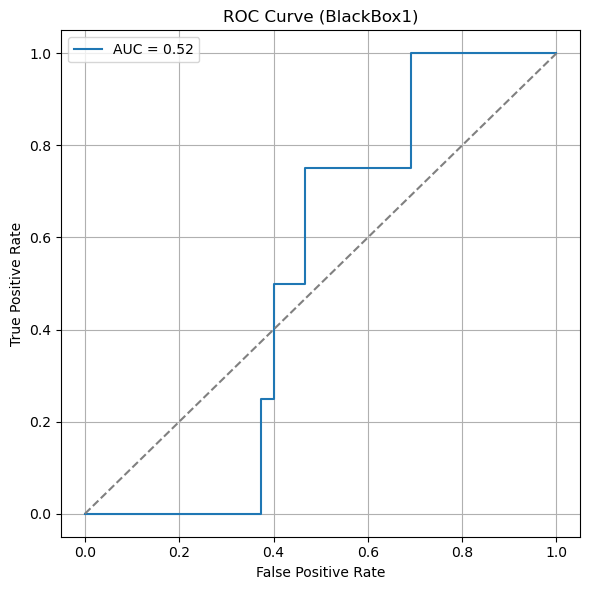

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Binary labels: 0 = background, 1 or 2 = signal
binary_labels = (np.array(y_bb1) > 0).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(binary_labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (BlackBox1)")
plt.grid(True)
plt.legend()
plt.tight_layout()

### Optional: Visualize Score Distributions

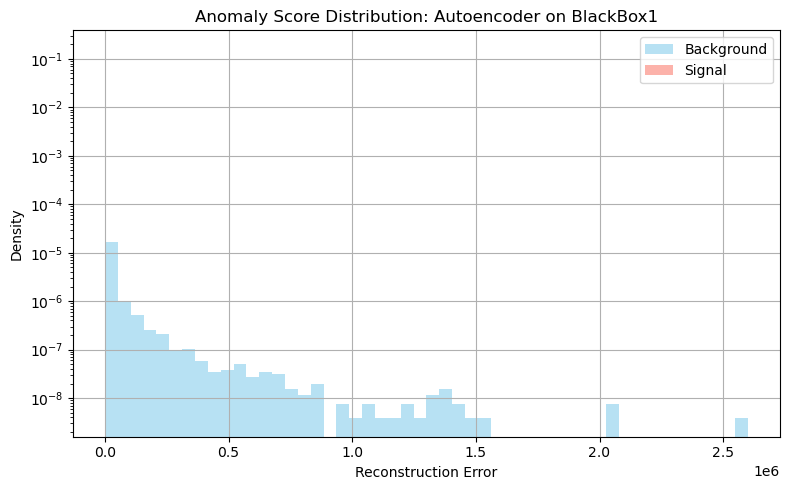

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(anomaly_scores[binary_labels == 0], bins=50, alpha=0.6, label="Background", color="skyblue", density=True)
plt.hist(anomaly_scores[binary_labels == 1], bins=50, alpha=0.6, label="Signal", color="salmon", density=True)
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.semilogy()
plt.title("Anomaly Score Distribution: Autoencoder on BlackBox1")
plt.legend()
plt.grid(True)
plt.tight_layout()